In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
%matplotlib inline
import time

In [6]:
df = pd.read_csv('applications data.csv')

In [3]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


In [4]:
# df['appyear'] = (df['date'] / 10000).astype('int')
# df['appmonth'] = ((df['date'] - df['appyear'] * 10000) / 100).astype('int')
# df['appday'] = df['date'] - df['appyear'] * 10000 - df['appmonth'] * 100
# df['date'] = pd.to_datetime(df.appyear*10000+df.appmonth*100+df.appday,format='%Y%m%d')
# df = df.drop(columns = ['appyear','appmonth','appday'])

In [7]:
# fix date
df['date']=pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))

In [8]:
# fix frivolous values in zip5
df['zip5']=df['zip5'].apply(lambda x: '{0:0>5}'.format(x))

In [9]:
# fix frivolous values in ssn
df.loc[df['ssn']==999999999,'ssn']=-df[df['ssn']==999999999]['record']
df['ssn']=df['ssn'].apply(lambda x: '{0:0>9}'.format(x))

In [10]:
# fix frivolous values in address
df.loc[df['address']=='123 MAIN ST','address']=df.loc[df['address']=='123 MAIN ST','record'].apply(lambda x: str(x)+' RECORD')

In [11]:
# dob
df.loc[df['dob']==19070626,'dob']=-df[df['dob']==19070626]['record']
df['dob']=df['dob'].apply(lambda x: '{0:0>8}'.format(x))

In [12]:
# homephone
df.loc[df['homephone']==9999999999,'homephone']=-df[df['homephone']==9999999999]['record']
df['homephone']=df['homephone'].apply(lambda x: '{0:0>9}'.format(x))

In [14]:
# check data types for the fields
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


#### Make day of week target encoding

In [13]:
df['dow']=df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [14]:
train_test=df[df['date']<'2016-11-01']

In [15]:
# statistical smoothing
c,nmid=4,20
y_avg=train_test['fraud_label'].mean()
y_dow=train_test.groupby('dow')['fraud_label'].mean()
num=train_test.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
df['dow_risk']=df['dow'].map(y_dow_smooth)

In [16]:
y_dow=y_dow.reset_index()
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')

In [17]:
train_test=0

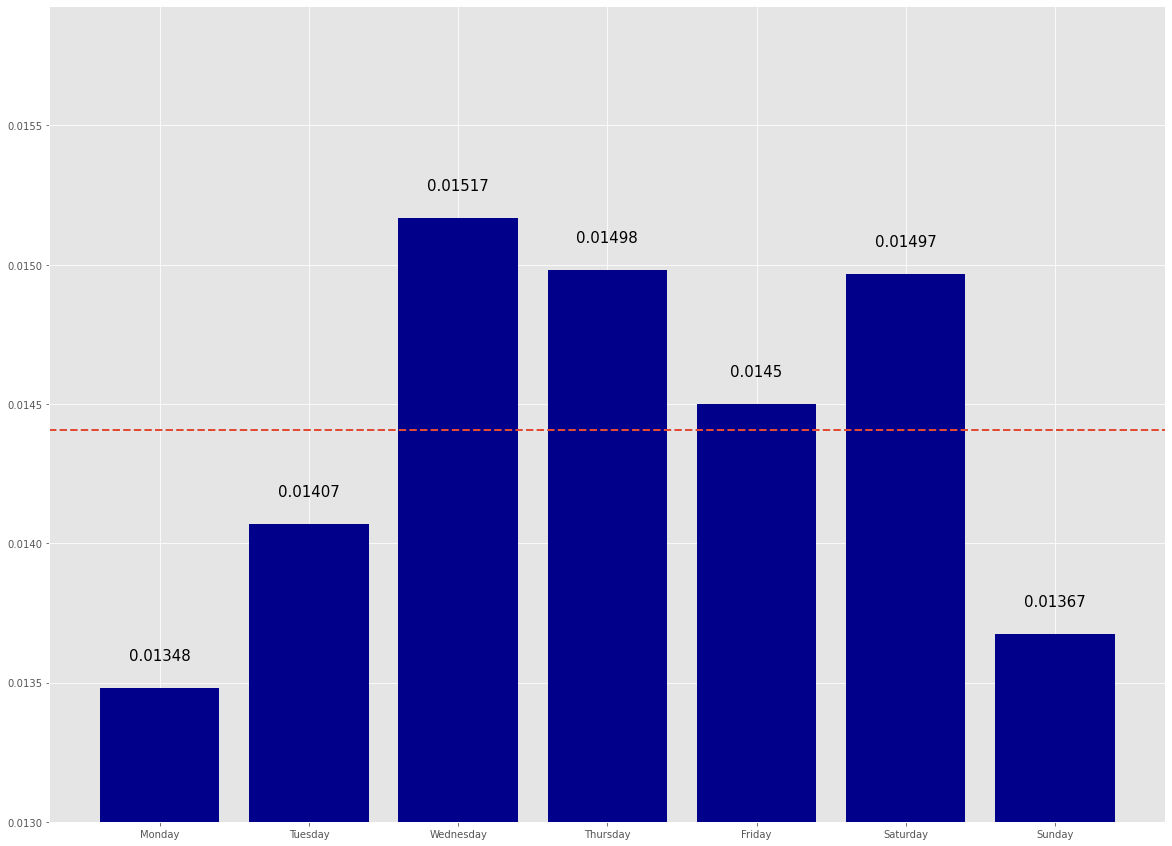

In [25]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(20,15))
plt.bar(data=y_dow,x=y_dow.index,height='fraud_label',color='darkblue')
ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg,ls='--',lw=2)
for i,v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[i,'fraud_label']+0.0001,round(y_dow.loc[i,'fraud_label'],5),horizontalalignment='center',fontsize=15)
plt.show()

### Make some new entites for variables

In [18]:
df['name']=df['firstname']+df['lastname']
df['fulladdress']=df['address']+df['zip5']
df['name_dob']=df['name']+df['dob']
df['name_fulladdress']=df['name']+df['fulladdress']
df['name_homephone']=df['name']+df['homephone']
df['fulladdress_dob']=df['fulladdress']+df['dob']
df['fulladdress_homephone']=df['fulladdress']+df['homephone']
df['dob_homephone']=df['dob']+df['homephone']
df['homephone_name_dob']=df['homephone']+df['name_dob']

In [27]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladdress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob'],
      dtype='object')

In [19]:
# connecting with ssn
for field in list(df.iloc[:,np.r_[3:9,12:15]].columns):
    df['ssn_'+field]=df['ssn']+df[field]

In [20]:
attributes=list(df.iloc[:,np.r_[2,5,7,8,12:30]].columns)

In [14]:
len(attributes)

22

In [17]:
df1=df.copy()
vars=df.copy()
df1['check_date']=df1['date']
df1['check_record']=df1['record']
vars.shape

(1000000, 30)

In [23]:
# save df1 to csv
df1.to_csv('df1.csv')

#### Velocity/counts and days since

In [18]:
begin=time.time()
for entity in attributes:
    st=time.time()
    df_1=df1[['record','date',entity]]
    df_r=df1[['check_record','check_date',entity]]
    temp=pd.merge(df_1,df_r,left_on=entity,right_on=entity)
    day_since_df=temp[temp['record']>temp['check_record']][['record','date','check_date']].groupby('record')[['date','check_date']].last()
    mapper=(day_since_df.date-day_since_df.check_date).dt.days
    vars[entity+'_day_since']=vars.record.map(mapper)
    vars[entity+'_day_since'].fillna(365,inplace=True)
    print(f'\n{entity}_day_since ---> Done')
    for offset_t in [0,1,3,7,14,30]:
        count_day_df=temp[(temp.check_date>=(temp.date-dt.timedelta(offset_t))) & (temp.record>=temp.check_record)]
        col_name=f'{entity}_count_{offset_t}'
        mapper2=count_day_df.groupby('record')[entity].count()
        vars[col_name]=vars.record.map(mapper2)
        print(f'{entity}_count_{str(offset_t)} ---> Done')
    print(f'Run time for entity {entity} ---- {time.time()-st}s')
print(f'Total run time: {(time.time()-begin)/60} min')


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for entity ssn ---- 7.58205246925354s

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
Run time for entity address ---- 7.678160905838013s

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
Run time for entity dob ---- 42.08792042732239s

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
Run time for entity homephone ---- 34.79369878768921s

name_day_since ---> Done
name_count_0 ---> Done
name_count_1 ---> Done
name_count_3 ---> Don

#### Relative Velocity

In [19]:
start=time.time()
for att in attributes:
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
            vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
print(f'Total run time: {time.time()-start}s')

Total run time: 9.12736177444458s


In [40]:
type(attributes)

list

In [20]:
to_remove = ["address", "dob", "name",'ssn_address','homephone','name_homephone','fulladdress_homephone','homephone_name_dob','ssn_homephone','ssn_firstname','ssn_dob','ssn_fulladdress','ssn_name_dob']

In [25]:
len(to_remove)

13

In [21]:
new_att = [x for x in attributes if (x not in to_remove)]

In [27]:
new_att

['ssn',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'fulladdress_dob',
 'dob_homephone',
 'ssn_lastname',
 'ssn_zip5',
 'ssn_name']

In [28]:
start=time.time()
vars.to_csv('vars.csv')
print(f'Time: {time.time()-start}s')

Time: 339.0555229187012s


#### Counts by entities

In [2]:
start=time.time()
vars = pd.read_csv('vars.csv')
print(f'Time: {time.time()-start}s')

Time: 96.76034498214722s


In [3]:
new_att=['ssn',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'fulladdress_dob',
 'dob_homephone',
 'ssn_lastname',
 'ssn_zip5',
 'ssn_name','ssn_name_dob']

In [4]:
start=time.time()
df1=pd.read_csv('df1.csv')
df1['date'] = pd.to_datetime(df1['date'])
df1['check_date'] = pd.to_datetime(df1['check_date'])
print(f'Time: {time.time()-start}s')

Time: 28.283364057540894s


In [5]:
begin=time.time()
for entity in new_att:
    for field in new_att:       
        st=time.time()
        if field==entity:
            continue
        else:
            df_c=df1[['record','date',entity]]
            df_d=df1[['check_record','check_date',entity,field]]
            temp=pd.merge(df_c,df_d,left_on=entity,right_on=entity)
        for offset_t in [1,3,7,14,30,60]:            
            count_day_df=temp[(temp.check_date>=(temp.date-dt.timedelta(offset_t)))&(temp.record>=temp.check_record)]            
            col_name=f'{entity}_unique_count_for_{field}_{offset_t}'
            mapper=count_day_df.groupby(['record'])[field].nunique()
            vars[col_name]=vars.record.map(mapper)
        print(f'Run time for entity {entity} in field {field} ---- {time.time()-st}s')
print(f'Total Run Time: {(time.time()-begin)/60} min')

Run time for entity ssn in field fulladdress ---- 13.441922426223755s
Run time for entity ssn in field name_dob ---- 12.20161771774292s
Run time for entity ssn in field name_fulladdress ---- 12.443025588989258s
Run time for entity ssn in field fulladdress_dob ---- 12.553300857543945s
Run time for entity ssn in field dob_homephone ---- 12.112350940704346s
Run time for entity ssn in field ssn_lastname ---- 11.525605201721191s
Run time for entity ssn in field ssn_zip5 ---- 11.268529415130615s
Run time for entity ssn in field ssn_name ---- 11.661279201507568s
Run time for entity ssn in field ssn_name_dob ---- 12.000585079193115s
Run time for entity fulladdress in field ssn ---- 11.32059621810913s
Run time for entity fulladdress in field name_dob ---- 12.016297578811646s
Run time for entity fulladdress in field name_fulladdress ---- 12.044286012649536s
Run time for entity fulladdress in field fulladdress_dob ---- 11.759082078933716s
Run time for entity fulladdress in field dob_homephone ---

MemoryError: Unable to allocate 2.47 GiB for an array with shape (332, 1000000) and data type int64

In [10]:
# currently there are 558 columns in vars
vars.shape

(1000000, 558)

In [7]:
# These two fields failed to run 'counts by entity' due to memory restraints
# will be run separately below
remained=['ssn_fulladdress','ssn_name_dob']
begin=time.time()
for entity in remained:
    for field in new_att:
        st=time.time()
        if field==entity:
            continue
        else:
            df_c=df1[['record','date',entity]]
            df_d=df1[['check_record','check_date',entity,field]]            
            temp=pd.merge(df_c,df_d,left_on=entity,right_on=entity)
            df_c,df_d=0,0
        for offset_t in [1,3,7,14,30,60]:
            count_day_df=temp[(temp.check_date>=(temp.date-dt.timedelta(offset_t)))&(temp.record>=temp.check_record)]
            col_name=f'{entity}_unique_count_for_{field}_{offset_t}'
            mapper=count_day_df.groupby(['record'])[field].nunique()
            vars[col_name]=vars.record.map(mapper)
            if KeyError or MemoryError:
                print(f'Not Enough Memory for {col_name}')
                continue
        if KeyError or MemoryError:
            print(f'Not Enough Memory for {col_name}')
            continue
    if KeyError or MemoryError:
        print(f'Not Enough Memory for {col_name}')
        continue
    print(f'Run time for entity {entity} in field {field} ---- {time.time()-st}s')
print(f'Total Run Time: {(time.time()-begin)/60} min')

MemoryError: Unable to allocate 2.48 GiB for an array with shape (333, 1000000) and data type int64

## The code below does not run properly

In [8]:
squared_df=pd.DataFrame()

In [ ]:
for col in list(vars.columns):
    if '_count_' in str(col):
        squared_df[col]=vars[col]

In [71]:
# we ended up with 401 variables in the separate data frame
squared_df.shape

(1000000, 401)

In [ ]:
for col in squared_df.columns:
    squared_df[col] = squared_df[col].apply(lambda x: x*x)

In [69]:
# new column names:
new_name={}
for col in list(squared_df.columns):
    new_name[col]=col+'_squared'

In [70]:
# change names of columns
squared_df.rename(columns = new_name, inplace = True)

In [ ]:
for col in squared_df.columns:
    vars=vars.join(squared_df[col])